In [13]:
!pip install geocoder
!pip install geopy
!pip install folium




import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinatesimport requests
from folium.plugins import MarkerCluster

  Obtaining dependency information for geocoder from https://files.pythonhosted.org/packages/4f/6b/13166c909ad2f2d76b929a4227c952630ebaf0d729f6317eb09cbceccbab/geocoder-1.38.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for ratelim from https://files.pythonhosted.org/packages/f2/98/7e6d147fd16a10a5f821db6e25f192265d6ecca3d82957a4fdd592cad49c/ratelim-0.1.6-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/98.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/98.6 kB ? eta -:--:--
   -------- ------------------------------- 20.5/98.6 kB 330.3 kB/s eta 0:00:01
   -------- ------------------------------- 20.5/98.6 kB 330.3 kB/s eta 0:00:01
   ------------ --------------------------- 30.7/98.6 kB 217.9 kB/s eta 0:00:01
   ------------ --------------------------- 30.7/98.6 kB 217.9 kB/s eta 0:00:01
   ------------ --------------------------- 30.7/98.6 kB 217.9 kB/s eta 0:00:01
   ---------------- ----------------------- 41.0/98

In [14]:
SVI_df = pd.read_csv('SoVI Mecklenburg County Census Tracts.csv')
FD_df = pd.read_csv('FD_df_LATLON.xlsx - CFD Data.csv')
MD_df = pd.read_csv('Medical_Facility_Data - Medical_Facility_Cleaned.csv')


In [15]:
#Deleting duplicates

counts = SVI_df.nunique()
to_del = [i for i, v in enumerate(counts) if v == 1]
print(to_del)

counts2 = SVI_df.nunique()
to_del2 = [i for i, v in enumerate(counts) if v == 0]
print(to_del2)

[0, 1, 2, 3, 4]
[]


In [16]:
# Combine the lists
columns_to_drop = list(set(to_del + to_del2))

# Drop columns from the DataFrame
SVI_df.drop(columns=SVI_df.columns[columns_to_drop], inplace=True)

SVI_df.drop("LOCATION", axis=1, inplace=True)

print(SVI_df.nunique())

FIPS            305
AREA_SQMI       305
E_TOTPOP        294
M_TOTPOP        251
E_HU            275
               ... 
MP_NHPI          37
EP_TWOMORE       72
MP_TWOMORE       69
EP_OTHERRACE     31
MP_OTHERRACE     44
Length: 152, dtype: int64


In [17]:
#looking for low variance columns

for i in range(SVI_df.shape[1]):
    num = SVI_df.iloc[:, i].nunique()
    perc = float(num) / SVI_df.shape[0] * 100
    if perc < 1:
        print(f"{SVI_df.columns[i]}: {num} unique values, {perc:.1f}%")

F_POV150: 3 unique values, 1.0%
F_UNEMP: 3 unique values, 1.0%
F_HBURD: 3 unique values, 1.0%
F_NOHSDP: 3 unique values, 1.0%
F_UNINSUR: 3 unique values, 1.0%
F_AGE65: 3 unique values, 1.0%
F_AGE17: 3 unique values, 1.0%
F_DISABL: 3 unique values, 1.0%
F_SNGPNT: 3 unique values, 1.0%
F_LIMENG: 3 unique values, 1.0%
F_MINRTY: 3 unique values, 1.0%
F_THEME3: 3 unique values, 1.0%
F_MUNIT: 3 unique values, 1.0%
F_MOBILE: 3 unique values, 1.0%
F_CROWD: 3 unique values, 1.0%
F_NOVEH: 3 unique values, 1.0%
F_GROUPQ: 3 unique values, 1.0%


In [18]:
#Formatting tracts

SVI_df['TRACT'] = (SVI_df['FIPS'] % 100000).astype(str)  # Extracting last 6 digits
SVI_df['TRACT'] = SVI_df['TRACT'].str.zfill(6)  # Padding with leading zeros if necessary
SVI_df = SVI_df.drop(columns=['FIPS'])
SVI_df.head()

,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV150,M_POV150,E_UNEMP,...,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,TRACT
0,0.252059,1103,391,694,218,652,205,171,179,21,...,13.9,1.5,1.2,0.0,3.6,9.2,8.1,0.0,3.6,000101
1,0.191456,2314,461,1981,275,1634,260,134,125,12,...,5.8,3.2,4.8,0.0,1.7,1.0,1.6,0.0,1.7,000102
2,0.069294,2137,277,1084,62,958,126,130,84,36,...,12.2,0.0,1.9,0.0,1.9,4.1,2.5,2.5,3.5,000103
3,0.236255,1156,261,1515,273,771,157,90,85,0,...,4.3,0.0,3.4,0.0,3.4,0.0,3.4,0.0,3.4,000104
4,0.075702,613,96,498,78,424,59,136,102,55,...,7.3,0.0,6.3,0.0,6.3,0.0,6.3,0.0,6.3,000301


In [19]:
#Column Selection

selected_columns = [
    "TRACT",
    "EP_POV150",
    "EP_UNEMP",
    "EP_HBURD",
    "EP_NOHSDP",
    "EP_UNINSUR",
    "EP_AGE65",
    "EP_AGE17",
    "EP_DISABL",
    "EP_SNGPNT",
    "EP_LIMENG",
    "EP_MINRTY",
    "EP_MUNIT",
    "EP_MOBILE",
    "EP_CROWD",
    "EP_NOVEH",
    "EP_GROUPQ",
]

SVI_df_t10 = SVI_df[selected_columns].copy()

In [20]:
#Checking for duplicates

dupes = SVI_df_t10.duplicated()
print(dupes.any)

<bound method NDFrame._add_numeric_operations.<locals>.any of 0      False
1      False
2      False
3      False
4      False
       ...  
300    False
301    False
302    False
303    False
304    False
Length: 305, dtype: bool>


In [21]:
#Transforming data using +1
SVI_trans = SVI_df_t10.applymap(lambda x: x + 1 if isinstance(x, int) else x)

#Fixing tracts that transformed incorrectly in a previous step
SVI_trans.loc[SVI_trans["TRACT"].str.endswith("080100"), "TRACT"] = SVI_trans["TRACT"].str.replace("080100", "009801")
SVI_trans.loc[SVI_trans["TRACT"].str.endswith("080200"), "TRACT"] = SVI_trans["TRACT"].str.replace("080200", "009802")
SVI_trans.loc[SVI_trans["TRACT"].str.endswith("080300"), "TRACT"] = SVI_trans["TRACT"].str.replace("080300", "009803")

# Printing the transformed DataFrame
print(SVI_trans)

      TRACT  EP_POV150  EP_UNEMP  EP_HBURD  EP_NOHSDP  EP_UNINSUR  EP_AGE65  \
0    000101       15.5       2.2      17.0        0.0        12.0       5.3   
1    000102        5.8       0.6      19.0        0.0         0.0       4.5   
2    000103        8.4       2.2      17.8        0.0         3.1       5.2   
3    000104        7.8       0.0      11.0        0.0        10.1      13.0   
4    000301       22.2      10.0      26.4        0.0         4.1       5.7   
..      ...        ...       ...       ...        ...         ...       ...   
300  006410       10.3       4.5      26.7        2.1         1.4      17.5   
301  006411       20.0       5.5      35.7        8.7        11.6      19.4   
302  009801        0.0    -999.0       0.0     -999.0      -999.0    -999.0   
303  009802        0.0    -999.0       0.0     -999.0      -999.0    -999.0   
304  009803        0.0       0.0       0.0        0.0         0.0      44.4   

     EP_AGE17  EP_DISABL  EP_SNGPNT  EP_LIMENG  EP_

In [22]:
#Veiwing FD_df preview
FD_df.head()

#Viewing census tracts within the DF
print(FD_df['TRACT'])

0      501
1      600
2     1100
3     1400
4     1608
5     1702
6     1914
7     1921
8     1923
9     2004
10    2006
11    2800
12    3008
13    3022
14    3110
15    3401
16    3802
17    3805
18    4000
19    4102
20    4302
21    4303
22    4600
23    5200
24    5510
25    5517
26    5533
27    5536
28    5604
29    5610
30    5616
31    5619
32    5832
33    5843
34    5847
35    5908
36    5910
37    5915
38    5916
39    6008
40    6110
41    9801
42    6306
43    6210
44    6305
45    6223
46    5833
47    5866
48    6411
49    6218
50    5714
51    5720
52    5824
Name: TRACT, dtype: int64


In [23]:
#Padding the Tracts with zeroes to match SVI
FD_df['TRACT'] = (FD_df['TRACT'] % 100000).astype(str)
FD_df['TRACT'] = FD_df['TRACT'].str.zfill(6)  

In [26]:
# Initialize map centered at Charlotte, NC
charlotte_map = folium.Map(location=[35.2271, -80.8431], zoom_start=10)

# Add markers for fire stations
for index, row in FD_df.iterrows():
    lat = row['LAT']
    lon = row['LON']
    folium.CircleMarker(location=[lat, lon], radius=3, color='blue', fill=True, fill_color='blue').add_to(charlotte_map)

# Display the map
charlotte_map

In [27]:
#Padding the Tracts with zeroes to match SVI
MD_df['TRACT'] = (MD_df['TRACT'] % 100000).astype(str)  # Extracting last 6 digits
MD_df['TRACT'] = MD_df['TRACT'].str.zfill(6)  # Padding with leading zeros if necessary

In [28]:
# Merge the two DataFrames based on their common columns
MDFD_df = pd.merge(MD_df, FD_df, on=['TRACT', 'NAME', 'ADDRESS', 'SERVTYPE', 'LAT', 'LON'], how='outer')

print(MDFD_df)

                                       NAME  \
0                     Arboretum Urgent Care   
1         Atrium Health Biddle Point Clinic   
2    Atrium Health Carolinas Medical Center   
3    Atrium Health Huntersville Surgery Ctr   
4           Atrium Health Levine Children's   
..                                      ...   
147              Fire Station 1 - Cornelius   
148              Fire Station 2 - Cornelius   
149              Fire Station 1 - Mint Hill   
150              Fire Station 2 - Mint Hill   
151              Fire Station 1 - Pineville   

                                  SERVTYPE  \
0      Doctors, Medical, Offices & Clinics   
1      Doctors, Medical, Offices & Clinics   
2    Hospitals, General Medical & Surgical   
3    Hospitals, General Medical & Surgical   
4      Doctors, Medical, Offices & Clinics   
..                                     ...   
147                                   Fire   
148                                   Fire   
149                  

In [29]:
# Define marker colors based on service types
service_colors = {
    'Doctors, Medical, Offices & Clinics': 'green',
    'Hospitals, General Medical & Surgical': 'red',
    'Hospitals, Specialty, Except Psychiatric': 'orange',
    'Fire': 'blue'
}

# Create a MarkerCluster object
marker_cluster = MarkerCluster().add_to(charlotte_map)

# Add markers for different service types to the marker cluster
for index, row in MDFD_df.iterrows():
    lat = row['LAT']
    lon = row['LON']
    service_type = row['SERVTYPE']
    marker_color = service_colors.get(service_type, 'black')
    folium.CircleMarker(location=[lat, lon], radius=3, color=marker_color, fill=True, fill_color=marker_color).add_to(marker_cluster)

#Creating a Legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 200px; height: 170px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: rgba(255, 255, 255, 0.7);
                 ">
         <b>Legend</b> <br>
         <span style="color:green">&nbsp;&nbsp;&nbsp;&#11044;&nbsp;</span> Doctors, Medical, Offices & Clinics <br>
         <span style="color:red">&nbsp;&nbsp;&nbsp;&#11044;&nbsp;</span> Hospitals, General Medical & Surgical <br>
         <span style="color:orange">&nbsp;&nbsp;&nbsp;&#11044;&nbsp;</span> Hospitals, Specialty, Except Psychiatric <br>
         <span style="color:blue">&nbsp;&nbsp;&nbsp;&#11044;&nbsp;</span> Fire <br>
      </div>
     '''

charlotte_map.get_root().html.add_child(folium.Element(legend_html))



# Display the map
charlotte_map

In [30]:
# Calculate the percentage of each SERVTYPE category for each TRACT
servtype_percentage = MDFD_df.groupby(['TRACT', 'SERVTYPE']).size().unstack(fill_value=0)
servtype_percentage = servtype_percentage.div(servtype_percentage.sum(axis=1), axis=0)

# Reset index to make TRACT a column instead of an index
servtype_percentage.reset_index(inplace=True)

tracts = SVI_trans['TRACT'].unique()
servtype_percentage = servtype_percentage.set_index('TRACT').reindex(tracts, fill_value=0).reset_index()

servtype_percentage.head()

SERVTYPE,TRACT,"Doctors, Medical, Offices & Clinics",Fire,"Hospitals, General Medical & Surgical","Hospitals, Specialty, Except Psychiatric"
0,000101,0.0,0.0,0.0,0.0
1,000102,0.0,0.0,0.0,0.0
2,000103,0.0,0.0,0.0,0.0
3,000104,0.0,0.0,0.0,0.0
4,000301,0.0,0.0,0.0,0.0


In [31]:
Clust_df = servtype_percentage.merge(SVI_trans[['TRACT','EP_AGE65', 'EP_POV150', 'EP_DISABL', 'EP_SNGPNT']], on='TRACT', how='left')
Clust_df[['EP_AGE65', 'EP_POV150', 'EP_DISABL', 'EP_SNGPNT']] = Clust_df[['EP_AGE65', 'EP_POV150', 'EP_DISABL', 'EP_SNGPNT']]/100
X = Clust_df[['Doctors, Medical, Offices & Clinics', 'Fire', 'Hospitals, General Medical & Surgical', 'Hospitals, Specialty, Except Psychiatric', 'EP_POV150']]
Xbins = X.copy()

<Figure size 1200x600 with 0 Axes>

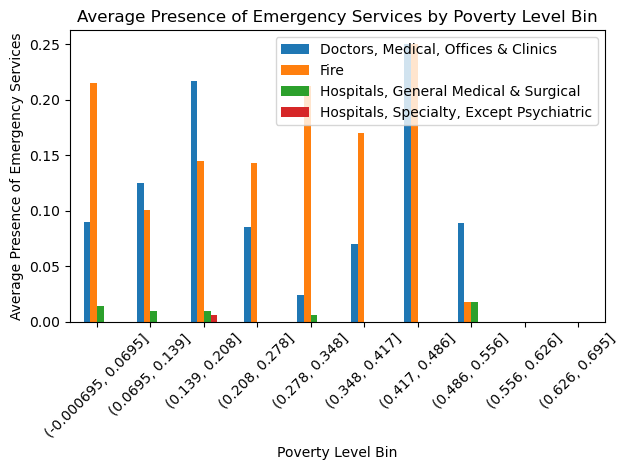

In [32]:
num_bins = 10

# Create bins for poverty levels
Xbins['PovertyLevelBin'] = pd.cut(Xbins['EP_POV150'], bins=num_bins)

# Calculate the average presence of each emergency service for each poverty level bin
average_services_by_bin = Xbins.groupby('PovertyLevelBin').mean()

# Plot the bar chart
plt.figure(figsize=(12, 6))
average_services_by_bin[['Doctors, Medical, Offices & Clinics', 'Fire', 'Hospitals, General Medical & Surgical', 'Hospitals, Specialty, Except Psychiatric']].plot(kind='bar', stacked=False)
plt.xlabel('Poverty Level Bin')
plt.ylabel('Average Presence of Emergency Services')
plt.title('Average Presence of Emergency Services by Poverty Level Bin')
plt.xticks(rotation=45)
plt.tight_layout()

#Save plot
plt.savefig('plt.jpg')

#Show plot
plt.show()

In [33]:
#Scaling features
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

#Running DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)

X_cluster = X.copy()
X_cluster['Cluster'] = clusters

print(clusters)

# Calculate silhouette score
silhouette_avg = silhouette_score(X_scaled, clusters)

print("Silhouette Score:", silhouette_avg)

# Calculate Davies-Bouldin index
db_index = davies_bouldin_score(X_scaled, clusters)

print("Davies-Bouldin Index:", db_index)

[ 0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  1  0  2  1  0  0  0  2
  0  0  0  0  0  0  1  0  0  2  0  0  0  2  1  0  0  0  0  0  1  0  1  0
  0  0  0  2  0  1  0  0  0  2  0  0 -1 -1  0  2  0  1  2  2  0  0  0  0
  0  2  2  0  0  0  0  2  0  0  0  1  0  2  0  0  0  1  0  0  0  0  0  0
  1  0 -1  0  0  0  1  1  2  0  0  0  0  0  0  2  0  1  2  1  1  0  0  0
  0  2  1  0  0  0  0  0  1  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0
  0  1  0  2  2  2  0  0  0  0  0  0  0  1  0  0  1  3  0  1  0  0  0  0
  1  0  0  1  2  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0
  0  3  0  0  1  0  0  0 -1  0  1  1  0  0  2  2  2  1  2  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  2  2  2  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  2
  0  0  0  1  0  0  0  0  0  0  0  1 -1  0  0  0  0  1  0  0  0  0  1  3
  1  1  0  2  0  0  0  0  0  0  0  2  0  1  1  0  0]
Silhouette Score: 0.6191241863791536
Davies-Bouldin Index: 1.0433094089

In [34]:
best_score = -1
best_epsilon = None
best_min_samples = None

# Define parameter ranges for grid search
epsilon_range = [0.5, 1.0, 1.5, 2.0]
min_samples_range = [3, 5, 10]

silhouette_score_list = []
parameters = []

# Perform grid search
for epsilon in epsilon_range:
    for min_samples in min_samples_range:
        #Run DBSCAN
        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled)
        
        #Calculate silhouette score
        silhouette = silhouette_score(X_scaled, clusters)

        silhouette_score_list.append(silhouette)
        parameters.append((epsilon, min_samples))

        if silhouette > best_score and -1 in clusters:
            best_score = silhouette
            best_epsilon = epsilon
            best_min_samples = min_samples

print("Best Silhouette Score:", best_score)
print("Best Epsilon:", best_epsilon)
print("Best Min Samples:", best_min_samples)

Best Silhouette Score: 0.6191241863791536
Best Epsilon: 2.0
Best Min Samples: 3


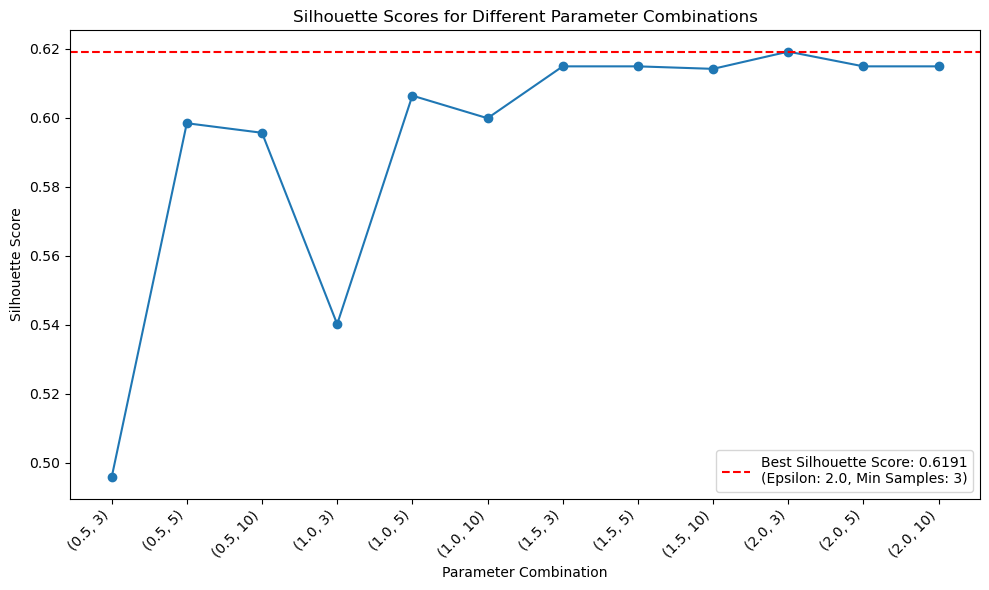

In [35]:
# Find the index of the best silhouette score
best_index = np.argmax(silhouette_score_list)

# Extract the best parameter values and silhouette score
best_epsilon, best_min_samples = parameters[best_index]
best_score = silhouette_score_list[best_index]

# Plot silhouette scores against parameter values
plt.figure(figsize=(10, 6))
plt.plot(range(len(silhouette_score_list)), silhouette_score_list, marker='o', linestyle='-')
plt.xlabel('Parameter Combination')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Parameter Combinations')
plt.xticks(range(len(silhouette_score_list)), parameters, rotation=45, ha='right')
plt.axhline(y=best_score, color='r', linestyle='--', label=f'Best Silhouette Score: {best_score:.4f}\n(Epsilon: {best_epsilon}, Min Samples: {best_min_samples})')
plt.legend()
plt.tight_layout()
plt.show()